In [1]:
from burstextractor.burstlist import download_burst_list, process_burst_list
from burstextractor.timeutils import extract_time, fix_typos_in_time, fix_24_hour_time, create_datetime, check_valid_date, adjust_year_month
from burstextractor.data_utils import explode_instruments_long_clean_instruments, keep_only_type_I_to_VI
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 

## Create Dataframe with the Burstlists

In [2]:
years = [2021, 2022, 2023]
months = range(1, 12+1)
burst_lists = []
for year in years:
    for month in months:
        if month > datetime.datetime.now().month and year == datetime.datetime.now().year:
            break
        download_burst_list(year, month)
        burst_lists.append(process_burst_list(f"e-CALLISTO_{year}_{month:02}.txt"))
burst_list = pd.concat(burst_lists).reset_index(drop=True)

/home/vincenzo/sunflare_prediction/burstextractor/burstlist.py:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(filename, sep="\t", index_col=False, encoding=ENCODING, names=col_names, engine="python", skiprows=skip_row_idxs, dtype=str)
/home/vincenzo/sunflare_prediction/burstextractor/burstlist.py:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv(filename, sep="\t", index_col=False, encoding=ENCODING, names=col_names, engine="python", skiprows=skip_row_idxs, dtype=str)


In [3]:
burst_list.sample(5)

,date,time,type,instruments
2513,20220508,01:16-01:16,III,"(ALASKA-COHOE), ALASKA-HAARP, Australia-ASSA"
206,20210521,19:50-19:50,III,MEXART
3869,20220926,19:15-19:44,VI,"ALASKA-COHOE, ALASKA-HAARP, Arecibo-Observator..."
2741,20220522,07:47-07:48,III,"AUSTRIA-UNIGRAZ, BIR, GLASGOW, HUMAIN, INDIA-G..."
1162,20211121,21:54-21:54,III,(Australia-ASSA)


In [4]:
burst_list.shape

(4828, 4)

## Fix typos

In [5]:
extracted_digits = burst_list['time'].str.extract(r'(\d+).(\d+).(\d+).(\d+)', expand=True).astype(int)

In [6]:
impossible_times_bool = (extracted_digits[1] > 59) | (extracted_digits[3] > 59) | (extracted_digits[0] > 23) | (extracted_digits[2] > 23)
extracted_digits[impossible_times_bool]

,0,1,2,3
1693,6,6,6,88
2238,24,32,14,33
3876,23,59,24,0
3890,0,0,24,0
3920,3,50,24,0
4179,23,59,24,0
4467,23,58,24,0
4557,0,0,24,0
4576,0,0,24,0


In [7]:
burst_list[impossible_times_bool]

,date,time,type,instruments
1693,20220210,06:06-06:88,V,"ALMATY, Australia-ASSA, INDIA-OOTY, INDIA-UDAI..."
2238,20220421,24:32-14:33,III,"AUSTRIA-MICHELBACH, Arecibo-Observatory, GLASG..."
3876,20220926,23:59:24:00,III,"ALASKA-COHOE, ALASKA-HAARP, Australia-ASSA"
3890,20220929,00:00-24:00,NaN,CTM
3920,20221001,03:50-24:00,CTM,*
4179,20221110,23:59-24:00,III,"ALASKA-COHOE, Australia-ASSA"
4467,20221215,23:58-24:00,III,Arecibo-Observatory
4557,20221221,00:00-24:00,CTM,*
4576,20221222,00:00-24:00,CTM,*


In [8]:
burst_list.loc[4179]

date                               20221110
time                            23:59-24:00
type                                    III
instruments    ALASKA-COHOE, Australia-ASSA
Name: 4179, dtype: object

In [9]:
burst_list.loc[4179+1]

date                 20221111
time              00:02-00:14
type                       VI
instruments    Australia-ASSA
Name: 4180, dtype: object

In [10]:
burst_list = fix_typos_in_time(burst_list)
burst_list = extract_time(burst_list)
burst_list = fix_24_hour_time(burst_list)
burst_list = create_datetime(burst_list)
burst_list = explode_instruments_long_clean_instruments(burst_list)
burst_list = keep_only_type_I_to_VI(burst_list)

In [11]:
burst_list.sample(5)

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
22023,20221224,07:55-08:10,VI,MRO,07:55,08:10,20221224,20221224,2022-12-24 07:55:00,2022-12-24 08:10:00
2665,20210829,01:30-01:33,III,Australia-ASSA,01:30,01:33,20210829,20210829,2021-08-29 01:30:00,2021-08-29 01:33:00
9458,20220427,11:18-11:19,III,HUMAIN,11:18,11:19,20220427,20220427,2022-04-27 11:18:00,2022-04-27 11:19:00
12315,20220531,01:20-01:20,III,ALASKA-HAARP,01:20,01:20,20220531,20220531,2022-05-31 01:20:00,2022-05-31 01:20:00
9617,20220429,03:43-03:57,VI,(Malaysia_Banting),03:43,03:57,20220429,20220429,2022-04-29 03:43:00,2022-04-29 03:57:00


## EDA

In [12]:
burst_list['duration'] = burst_list['datetime_end'] - burst_list['datetime_start']

In [13]:
# Mean duration of bursts in minutes
(burst_list.duration.dt.total_seconds()/60).describe().astype(int)

count    21897
mean         9
std         75
min       -479
25%          0
50%          1
75%          5
max       1439
Name: duration, dtype: int64

In [14]:
burst_list = burst_list[burst_list.duration.dt.total_seconds() > 0]
burst_list = burst_list.explode('instruments')
burst_list.instruments = burst_list.instruments.str.strip()

In [15]:
burst_list

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end,duration
18,20210223,05:43-05:44,III,KRIM,05:43,05:44,20210223,20210223,2021-02-23 05:43:00,2021-02-23 05:44:00,0 days 00:01:00
29,20210227,17:58-18:01,III,ALASKA-HAARP,17:58,18:01,20210227,20210227,2021-02-27 17:58:00,2021-02-27 18:01:00,0 days 00:03:00
30,20210227,17:58-18:01,III,GREENLAND,17:58,18:01,20210227,20210227,2021-02-27 17:58:00,2021-02-27 18:01:00,0 days 00:03:00
31,20210227,18:07-18:08,III,GREENLAND,18:07,18:08,20210227,20210227,2021-02-27 18:07:00,2021-02-27 18:08:00,0 days 00:01:00
32,20210228,06:45-06:51,III,ALMATY,06:45,06:51,20210228,20210228,2021-02-28 06:45:00,2021-02-28 06:51:00,0 days 00:06:00
...,...,...,...,...,...,...,...,...,...,...,...
22937,20230109,08:45-08:52,III,MRO,08:45,08:52,20230109,20230109,2023-01-09 08:45:00,2023-01-09 08:52:00,0 days 00:07:00
22938,20230109,08:45-08:52,III,(MRT1),08:45,08:52,20230109,20230109,2023-01-09 08:45:00,2023-01-09 08:52:00,0 days 00:07:00
22939,20230109,08:45-08:52,III,NORWAY-EGERSUND,08:45,08:52,20230109,20230109,2023-01-09 08:45:00,2023-01-09 08:52:00,0 days 00:07:00
22940,20230109,08:45-08:52,III,SSRT,08:45,08:52,20230109,20230109,2023-01-09 08:45:00,2023-01-09 08:52:00,0 days 00:07:00


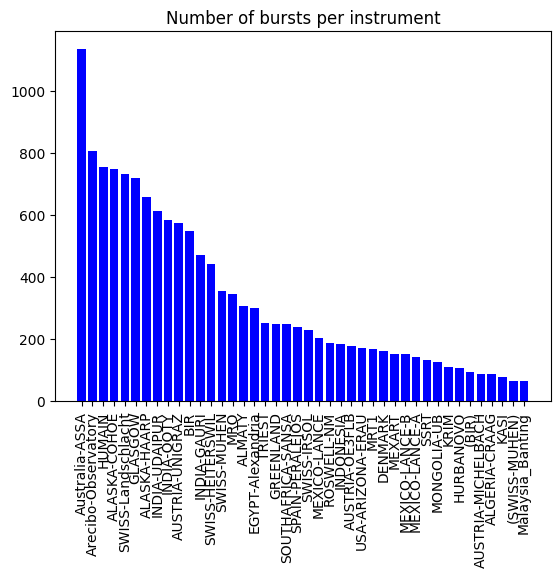

In [16]:
instrument_count = burst_list.instruments.value_counts()
instrument_count = instrument_count[instrument_count > 60]
plt.bar(instrument_count.index, instrument_count.values, color='blue')
plt.xticks(rotation=90)
plt.title('Number of bursts per instrument')
plt.show()

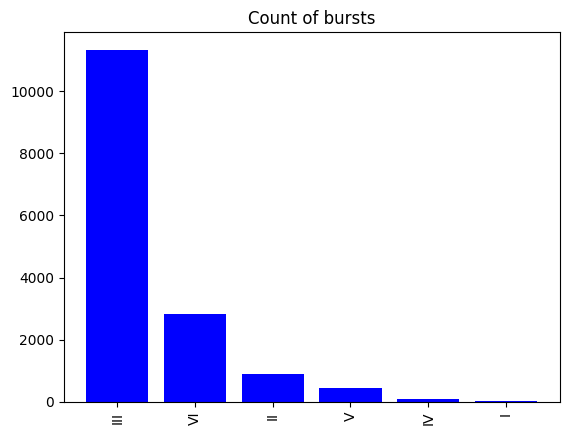

In [17]:
type_count = burst_list.type.value_counts()
plt.bar(type_count.index, type_count.values, color='blue')
plt.xticks(rotation=90)
plt.title('Count of bursts')
plt.show()

<AxesSubplot: title={'center': 'Type per top 10 instruments'}, xlabel='instruments'>

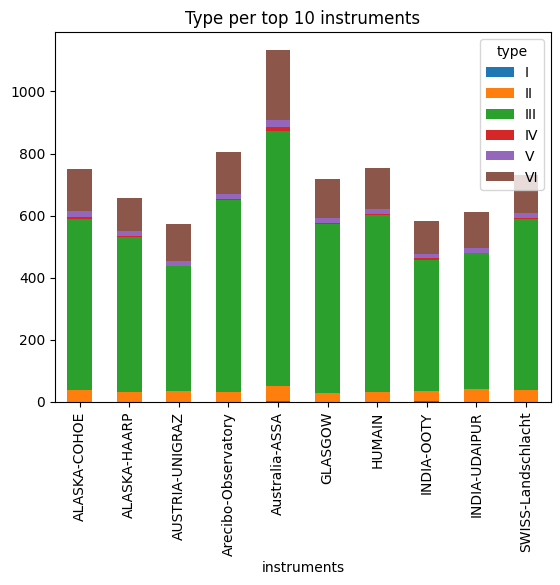

In [18]:
# Type per top 10 instruments
burst_list[burst_list.instruments.isin(instrument_count.index[:10])].groupby(['instruments', 'type']).size().unstack().plot(kind='bar', stacked=True, title='Type per top 10 instruments')

In [19]:
burst_list.duration

18      0 days 00:01:00
29      0 days 00:03:00
30      0 days 00:03:00
31      0 days 00:01:00
32      0 days 00:06:00
              ...      
22937   0 days 00:07:00
22938   0 days 00:07:00
22939   0 days 00:07:00
22940   0 days 00:07:00
22941   0 days 00:07:00
Name: duration, Length: 15613, dtype: timedelta64[ns]

In [20]:
burst_list.groupby('type').duration.mean()

type
I     0 days 00:12:14.482758620
II    0 days 00:13:07.887640449
III   0 days 00:02:58.168343038
IV              0 days 00:45:34
V     0 days 00:04:03.724137931
VI    0 days 00:56:39.809523809
Name: duration, dtype: timedelta64[ns]

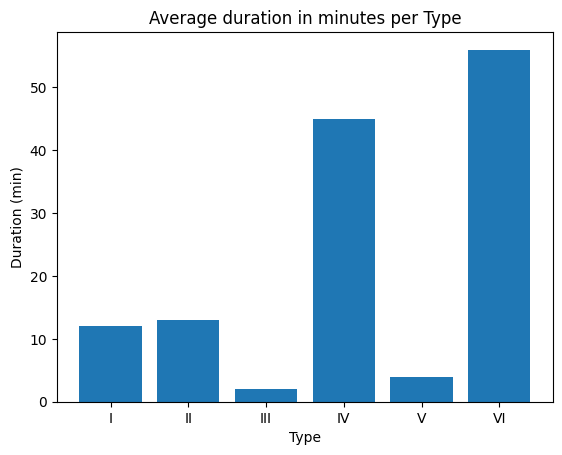

In [21]:
# Average duration per type of burst
avg_duration_type = burst_list.groupby('type').duration.mean().dt.seconds // 60
plt.bar(avg_duration_type.index, avg_duration_type)
plt.xlabel('Type')
plt.ylabel('Duration (min)')
plt.title('Average duration in minutes per Type')
plt.show()

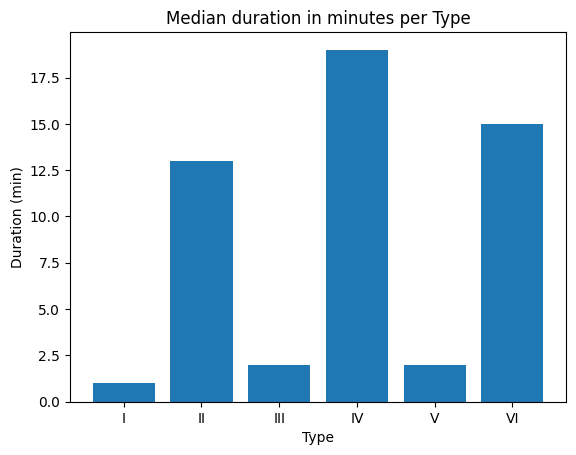

In [22]:
median_duration_type = burst_list.groupby('type').duration.median().dt.seconds // 60
plt.bar(median_duration_type.index, median_duration_type)
plt.xlabel('Type')
plt.ylabel('Duration (min)')
plt.title('Median duration in minutes per Type')
plt.show()

## Get some spectograms

In [23]:
from astropy.io import fits
from astropy.table import Table
from astropy.utils.data import get_pkg_data_filename

In [24]:
URL = 'http://soleil80.cs.technik.fhnw.ch/solarradio/data/2002-20yy_Callisto/2023/01/01/ALASKA-ANCHORAGE_20230101_000904_01.fit.gz'
Table.read(URL, format='fits')

TIME,FREQUENCY
float64[3600],float64[200]
0.0 .. 899.75,65.875 .. 5.0


In [25]:
from radiospectra.sources import CallistoSpectrogram

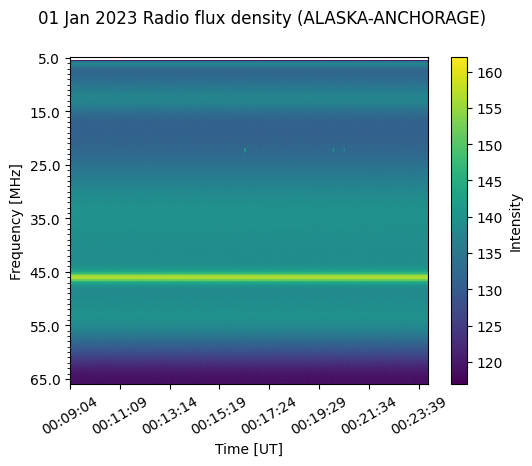

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [26]:
spec = CallistoSpectrogram.read(URL)
spec.peek()

## Improve existing spectogram functions

In [27]:
from spectogram_utils import *

In [52]:
pd_data = spec_to_pd_dataframe(spec)
pd_data.head(5)

,65.875000,65.563004,65.250000,64.938004,64.625000,64.313004,64.000000,63.688000,63.375000,63.063000,...,6.500000,6.188000,5.875000,5.563000,5.250000,5.000000,5.000000,5.000000,5.000000,5.000000
2023-01-01 00:09:04.868,119.0,118.0,118.0,119.0,119.0,119.0,120.0,120.0,120.0,121.0,...,135.0,139.0,135.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:05.118,120.0,119.0,118.0,119.0,119.0,119.0,120.0,120.0,121.0,121.0,...,136.0,139.0,135.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:05.368,119.0,119.0,119.0,120.0,119.0,119.0,120.0,120.0,120.0,121.0,...,137.0,139.0,135.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:05.618,119.0,118.0,119.0,119.0,120.0,119.0,120.0,120.0,121.0,121.0,...,136.0,138.0,135.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:05.868,119.0,120.0,118.0,119.0,119.0,120.0,120.0,120.0,120.0,121.0,...,137.0,138.0,135.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
change_resolution_over_time(pd_data, 1800).head(5)

,65.875000,65.563004,65.250000,64.938004,64.625000,64.313004,64.000000,63.688000,63.375000,63.063000,...,6.500000,6.188000,5.875000,5.563000,5.250000,5.000000,5.000000,5.000000,5.000000,5.000000
2023-01-01 00:09:04.868000000,119.5,118.5,118.0,119.0,119.0,119.0,120.0,120.0,120.5,121.0,...,135.5,139.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:05.368138966,119.0,118.5,119.0,119.5,119.5,119.0,120.0,120.0,120.5,121.0,...,136.5,138.5,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:05.868277932,119.0,119.5,119.0,119.0,119.0,119.5,119.5,120.5,120.5,121.0,...,136.5,138.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:06.368416898,119.0,118.5,118.5,118.5,119.0,119.0,120.0,120.0,120.0,122.0,...,136.0,138.5,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:09:06.868555864,119.0,119.0,119.5,119.0,119.5,119.0,120.0,120.0,120.5,121.0,...,135.5,139.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
def plot_spectogram(spectogram, max_x_labels=30):
    spectogram = spectogram.copy()
    spectogram.index = spectogram.index.strftime('%Y-%m-%d %H:%M:%S')
    sns.heatmap(spectogram.T, cmap='viridis', cbar_kws={'label': 'Flux (W/m^2)'})

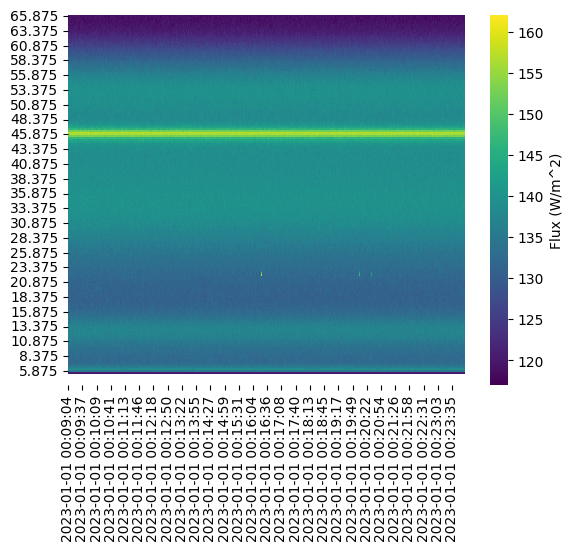

In [79]:
plot_spectogram(pd_data)

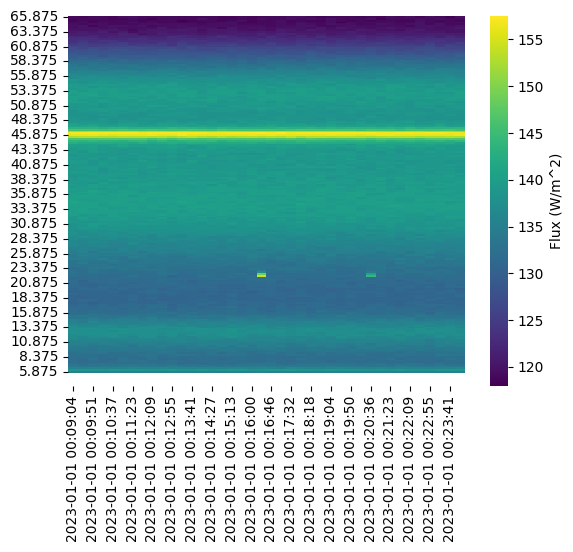

In [80]:
plot_spectogram(change_resolution_over_time(pd_data, 40))